#**Install the necessary libraries**

In [2]:
pip install qai-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 70.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


In [3]:
!qai-hub configure --api_token 00263f5bbf494c5720f6bd2cc97312a8ed6c5647

qai-hub configuration saved to /root/.qai_hub/client.ini
==================== /root/.qai_hub/client.ini ====================
[api]
api_token = 00263f5bbf494c5720f6bd2cc97312a8ed6c5647
api_url = https://app.aihub.qualcomm.com
web_url = https://app.aihub.qualcomm.com
verbose = True




In [4]:
!pip -q install qai-hub qai-hub-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.8/402.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#**Download and Clean the Dataset**

In [5]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   102M      0  0:00:07  0:00:07 --:--:--  100M


In [6]:
# unzip the downloaded file to extract its contents
!unzip -q kagglecatsanddogs_5340.zip

In [7]:
# list the extracted contents
!ls PetImages

Cat  Dog


**Clean the dataset by removing corrupted or invalid images (Data Cleaning)**

In [8]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


#**Load Libraries and Initialize Hyperparameters**

In [9]:
import torch
import torch.nn as nn    # building and training the neural network
import torch.optim as optim   # optimization
from torchvision import datasets, transforms, models   # image transformations and pre-trained models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt      # visualizations

# Hyperparameters
batch_size = 32          # images per training step
num_epochs = 5           # number of times the model will see the entire dataset
learning_rate = 0.001    # step size for the optimizer
validation_split = 0.2   # 20% of the data used for validation

data_dir = 'PetImages'

#**Preprocess the Dataset**

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation: randomly flip images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the dataset (ImageFolder automatically assigns classes in alphabetical order)
full_dataset = datasets.ImageFolder(data_dir)


# Splitting dataset into training and validation subsets
total_size = len(full_dataset)
val_size = int(total_size * validation_split)
train_size = total_size - val_size

# Applying the respective transformations to both the training and validation datasets and split them accordingly
train_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(data_dir, transform=val_transform)

# Split the datasets using random_split
train_dataset, _ = random_split(train_dataset, [train_size, val_size])
_, valid_dataset = random_split(valid_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # shuffle the data to ensure the model encounters a varied order of images during training
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False) # Not shuffle the data, as it is used strictly for evaluation

#**Initialize the Model**

In [11]:
# Load ResNet18 pre-trained on ImageNet
model = models.resnet18(pretrained=True)

for name, param in model.named_parameters():
    # Only unfreeze parameters in layer4 and fc
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace the final layer to suit our binary classification
model.fc = nn.Linear(model.fc.in_features, 2)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


#**Training the Model**

In [12]:
# Loss and optimizer (all parameters with requires_grad=True will be updated)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)
            total_preds += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_preds.double() / total_preds

        model.eval()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == labels)
                total_preds += labels.size(0)

        valid_loss = running_loss / len(valid_loader)
        valid_accuracy = correct_preds.double() / total_preds

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy.item())
        valid_accuracies.append(valid_accuracy.item())

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

# Train the model
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs
)

Epoch 1/5
Train Loss: 0.0854, Train Acc: 0.9678
Valid Loss: 0.0328, Valid Acc: 0.9874
Epoch 2/5
Train Loss: 0.0510, Train Acc: 0.9816
Valid Loss: 0.0322, Valid Acc: 0.9889
Epoch 3/5
Train Loss: 0.0462, Train Acc: 0.9832
Valid Loss: 0.0290, Valid Acc: 0.9885
Epoch 4/5
Train Loss: 0.0303, Train Acc: 0.9884
Valid Loss: 0.0226, Valid Acc: 0.9934
Epoch 5/5
Train Loss: 0.0297, Train Acc: 0.9902
Valid Loss: 0.0202, Valid Acc: 0.9940


In [13]:
# Saving the trained model
torch.save(model.state_dict(), 'cats_and_dogs_model_finetuned.pth')
print("Model saved as cats_and_dogs_model_finetuned.pth")

Model saved as cats_and_dogs_model_finetuned.pth


#**Testing the Model**

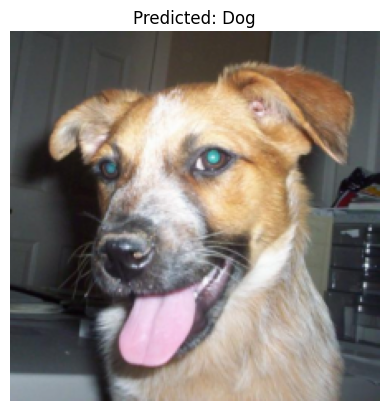

In [14]:
import random

dataset = datasets.ImageFolder(data_dir, transform=val_transform)

def predict_random_image():
    # Get a random index from the dataset
    idx = random.randint(0, len(dataset) - 1)
    img, label = dataset[idx]

    img = img.unsqueeze(0).to(device)  # Add batch dimension and move to the device

    # Make a prediction
    with torch.no_grad():
        outputs = model(img)  # Get model's output
        _, predicted = torch.max(outputs, 1)  # Get the predicted class index

    # Map the predicted class index back to 'Cat' or 'Dog'
    class_names = dataset.classes
    predicted_class = class_names[predicted.item()]

    # Normalize the image back to [0, 1] for visualization
    img = img.squeeze(0).cpu()  # Remove batch dimension and move to CPU

    # Undo the normalization from the model
    unnormalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                             std=[1/0.229, 1/0.224, 1/0.225])
    ])
    img = unnormalize(img)

    # Convert tensor to PIL image for display
    img = transforms.ToPILImage()(img)

    # Display the image
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

# Call the function to predict and display a random image
predict_random_image()

#**Compile the Model for Qualcomm-Compatible Format**

In [15]:
import qai_hub as hub

devices = [
    "Samsung Galaxy S22 Ultra 5G",
    "Samsung Galaxy S22 5G",
    "Samsung Galaxy S22+ 5G",
    "Samsung Galaxy Tab S8",
    "Xiaomi 12",
    "Xiaomi 12 Pro",
    "Samsung Galaxy S22 5G",
    "Samsung Galaxy S23",
    "Samsung Galaxy S23+",
    "Samsung Galaxy S23 Ultra",
    "Samsung Galaxy S24",
    "Samsung Galaxy S24 Ultra",
    "Samsung Galaxy S24+",
]
selected_device = random.choice(devices)
print(f"Selected device: {selected_device}")

Selected device: Samsung Galaxy Tab S8


In [16]:
# Initialize the model and load the trained weights
# Not pre-trained because we are loading our weights
device_model = models.resnet18(pretrained=False)
device_model.fc = torch.nn.Linear(device_model.fc.in_features, 2)

# Save the model's state_dict
torch.save(model.state_dict(), "cats_and_dogs_model.pth")

# Load the trained weights
device_model.load_state_dict(torch.load("cats_and_dogs_model.pth"))
device_model.eval()

scripted_device_model = torch.jit.script(device_model)
# Save the scripted model to a file
scripted_device_model.save("cats_and_dogs_scripted.pt")

# Load the scripted model
uploaded_scripted_model = torch.jit.load("cats_and_dogs_scripted.pt")
uploaded_model = hub.upload_model(uploaded_scripted_model, name="Cats_and_Dogs_Model")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-16-e99481a9ccc5>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Uploading tmpuyvo87ke.pt


100%|██████████| 42.8M/42.8M [00:01<00:00, 28.9MB/s]


In [17]:
hub_device = hub.Device(selected_device)

# Example input shape: (batch_size=1, channels=3, height=224, width=224)
input_shape_hub = (1, 3, 224, 224)  # ResNet18 expects 224x224 input images

# Submit the compile job
compile_job_hub = hub.submit_compile_job(
    uploaded_model,
    device=hub_device,
    name="Cats_and_Dogs_Model (1, 3, 224, 224)",
    input_specs=dict(x=input_shape_hub),
)

# Get the compiled model
compiled_device_model = compile_job_hub.get_target_model()

Scheduled compile job (jgozvn3qp) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jgozvn3qp/

Waiting for compile job (jgozvn3qp) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          


#**Profile the Model's Performance**

In [18]:
from qai_hub_models.utils.printing import print_profile_metrics_from_job

# Submit a performance profile job on the device
performance_profile_job = hub.submit_profile_job(
    model=compiled_device_model,
    device=hub_device,
)

# Download and print the profile metrics
performance_data = performance_profile_job.download_profile()
print_profile_metrics_from_job(performance_profile_job, performance_data)

Scheduled profile job (jg904y4wg) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jg904y4wg/

Waiting for profile job (jg904y4wg) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          

------------------------------------------------------------
Performance results on-device for Job_Jgozvn3Qp_Optimized_Tflite.
------------------------------------------------------------
Device                          : Samsung Galaxy Tab S8 (12)
Runtime                         : TFLITE                    
Estimated inference time (ms)   : 1.5                       
Estimated peak memory usage (MB): [0, 16]                   
Total # Ops                     : 37                        
Compute Unit(s)                 : NPU (37 ops)              
------------------------------------------------------------
More details: https://app.aihub.qualcomm.com/jobs/jg904y4wg/



#**Testing the Model On-Device**

Selected image from 'Cat': PetImages/Cat/3042.jpg


Uploading dataset: 205kB [00:00, 287kB/s]                    


Scheduled inference job (jp04r219g) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jp04r219g/

Waiting for inference job (jp04r219g) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          


tmp2vl2oe83.h5: 100%|██████████| 13.9k/13.9k [00:00<00:00, 11.0MB/s]

Predicted Label: Cat


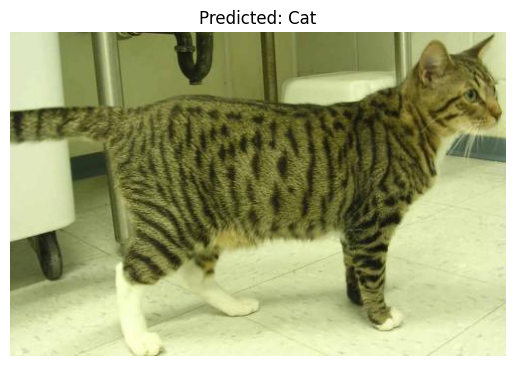

In [19]:
import numpy as np
from PIL import Image

class_names = ["Cat", "Dog"]

# Randomly choose a class folder
selected_class = random.choice(class_names)
class_dir = os.path.join(data_dir, selected_class)

image_files = [
    os.path.join(class_dir, fname)
    for fname in os.listdir(class_dir)
    if fname.lower().endswith('.jpg')
]

# Randomly select one image file
img_path = random.choice(image_files)
print(f"Selected image from '{selected_class}': {img_path}")

selected_image_pil = Image.open(img_path).convert("RGB")

# Define the transformation exactly as used during training
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Apply the transform to the raw image for inference
model_ready_input_tensor = inference_transform(selected_image_pil).unsqueeze(0)  # Add batch dimension

# Convert to numpy array
model_ready_input_numpy = model_ready_input_tensor.numpy().astype(np.float32)

# Prepare inputs for inference
inference_inputs = {"x": [model_ready_input_numpy]}

# Submit inference job
inference_job_hub = hub.submit_inference_job(
    model=compiled_device_model,
    inputs=inference_inputs,
    device=hub_device,
)

# Get inference results
ondevice_inference_output = inference_job_hub.download_output_data()
output_logits = ondevice_inference_output["output_0"][0]

# Determine the predicted class
predicted_class_index = np.argmax(output_logits)
predicted_class = class_names[predicted_class_index]

print(f"Predicted Label: {predicted_class}")

plt.imshow(selected_image_pil)
plt.title(f'Predicted: {predicted_class}')
plt.axis('off')
plt.show()